# Import Libraries needed

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Note: We are going to be importing libraries as needed, in order to have more clarity on 
# what's to realted to which section

#1. Read Data

In [93]:
df_train = pd.read_csv("cleaned_data/train_data_cl.csv")
df_test = pd.read_csv("cleaned_data/test_data_cl.csv")

display(df_train.head())
display(df_train.info())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck
0,0.0,3,0,-0.562845,0.729948,0.0,-0.865509,0.339009,0.156673,0.299854
1,1.0,1,1,0.657637,0.729948,0.0,1.330622,0.553571,0.791989,0.589066
2,1.0,3,1,-0.257725,0.000000,0.0,-0.797636,0.339009,0.697802,0.299854
3,1.0,1,1,0.428796,0.729948,0.0,0.995065,0.339009,0.791989,0.589066
4,0.0,3,0,0.428796,0.000000,0.0,-0.785550,0.339009,0.156673,0.299854


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  881 non-null    float64
 1   Pclass    881 non-null    int64  
 2   Sex       881 non-null    int64  
 3   Age       881 non-null    float64
 4   SibSp     881 non-null    float64
 5   Parch     881 non-null    float64
 6   Fare      881 non-null    float64
 7   Embarked  881 non-null    float64
 8   Title     881 non-null    float64
 9   Deck      881 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 69.0 KB


None

### Tweak a bit our training data and feature selection:


In [94]:
# Separating features and target
X = df_train.drop('Survived', axis = 1)
y = df_train[['Survived']].astype('int')

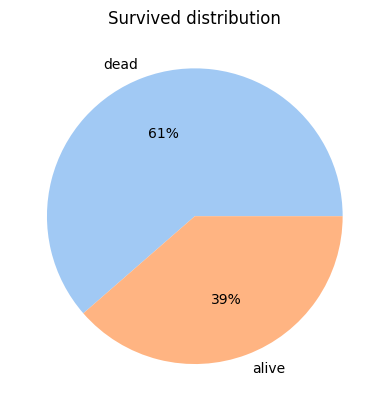

In [95]:
pieid = y["Survived"].value_counts()

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie( pieid.values, labels = ["dead","alive"], colors = colors, autopct='%.0f%%')

plt.title("Survived distribution")
plt.show()

We now have 61/39 of survival on our train data. Let's make new data to make it 50/50 ith SMOTE
This is in preparation of the GBR model we are going to fit.

In [96]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state = 0)

X_resampled, y_resampled = smote.fit_resample(X,y)
print(sorted(Counter(y_resampled).items()), y_resampled.shape)

[('Survived', 1)] (1082, 1)


We have generated up to 1082 rows.

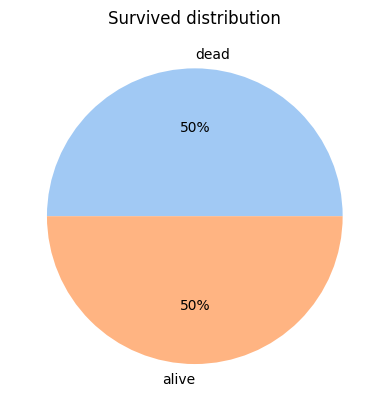

In [97]:
pieid = y_resampled["Survived"].value_counts()

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie( pieid.values, labels = ["dead","alive"], colors = colors, autopct='%.0f%%')

plt.title("Survived distribution")
plt.show()

So now we have even data.

# Feature selection

In [98]:
from sklearn.feature_selection import VarianceThreshold

first_method = VarianceThreshold(threshold= 0.01)
first_method.fit(X_resampled)
selected_mask = first_method.get_support()
X_resampled.columns[selected_mask]

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Title', 'Deck'], dtype='object')

In [99]:
X_resampled = X_resampled[X_resampled.columns[selected_mask]]  

# Modeling


In [100]:
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def hyper_param_tune (model, params ):
    dt_clf = GridSearchCV(model, params, cv=2, return_train_score=False)
    dt_clf.fit(X, y)
    print("Model best parameters:", dt_clf.best_params_)
    return dt_clf.best_params_

def modelling( model, X_resampled , y_resampled , param = None):
    X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2)
    if param == None:
        Model = model()
    else:
        Model = model(**param)
    # Fit model
    Model.fit(X_train, y_train)

    # get predicted prices on validation data
    val_predictions = Model.predict(X_valid)
    mae = metrics.mean_absolute_error(y_valid, val_predictions)
    prec = metrics.accuracy_score(y_valid, val_predictions)
    accur = metrics.precision_score(y_valid, val_predictions)
    print("MAE:",mae)
    print("Precision:",prec)
    print("Accuracy:",accur)
    return mae,prec,accur
    

#### Decision Tree

+ ##### Easy stupid way:

In [101]:
from sklearn.tree import DecisionTreeClassifier

modelling( DecisionTreeClassifier, X_resampled , y_resampled)

MAE: 0.2073732718894009
Precision: 0.7926267281105991
Accuracy: 0.7297297297297297


(0.2073732718894009, 0.7926267281105991, 0.7297297297297297)

You get not so bad values, but seems pretty random how it goes, so we are going to choose some parameterers for the model.
+ #### More thoughtful way:
Choose the Best Hyperparameter Using GridSearchCV Hyperparameter Tuning.

In [110]:

# DecisionTreeClassifier
dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 4, 5, 8],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_depth': [None, 10, 20, 30, 40, 50, 60],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
dt_hyper_param = hyper_param_tune( DecisionTreeClassifier(), dt_params )


DecisionTreeClassifier best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'splitter': 'random'}


In [109]:
modelling( DecisionTreeClassifier, X_resampled, y_resampled, param = dt_hyper_param )

MAE: 0.17972350230414746
Precision: 0.8202764976958525
Accuracy: 0.7946428571428571


(0.17972350230414746, 0.8202764976958525, 0.7946428571428571)

#### Random Forest

+ ##### Easy stupid way:

In [121]:
from sklearn.ensemble import RandomForestClassifier

modelling( RandomForestClassifier, X_resampled , y_resampled )

MAE: 0.15668202764976957
Precision: 0.8433179723502304
Accuracy: 0.8282828282828283


(0.15668202764976957, 0.8433179723502304, 0.8282828282828283)

+ #### More thoughtful way:

In [124]:

# Random Forest Classifier
rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}
rf_hyper_param = hyper_param_tune( RandomForestClassifier(), rf_params )


DecisionTreeClassifier best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
MAE: 0.12442396313364056
Precision: 0.8755760368663594
Accuracy: 0.8611111111111112


(0.12442396313364056, 0.8755760368663594, 0.8611111111111112)

In [125]:
modelling( RandomForestClassifier, X_resampled, y_resampled, param = rf_hyper_param )

MAE: 0.1152073732718894
Precision: 0.8847926267281107
Accuracy: 0.8942307692307693


(0.1152073732718894, 0.8847926267281107, 0.8942307692307693)

#### Logistic Regression

+ ##### Easy stupid way:

In [132]:
from sklearn.linear_model import LogisticRegression

modelling( LogisticRegression, X_resampled , y_resampled)

MAE: 0.20276497695852536
Precision: 0.7972350230414746
Accuracy: 0.819047619047619


(0.20276497695852536, 0.7972350230414746, 0.819047619047619)

+ #### More thoughtful way:

In [133]:

# Logistic Regression Classifier
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

lr_hyper_param = hyper_param_tune( LogisticRegression(), lr_params )

DecisionTreeClassifier best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [134]:
modelling( LogisticRegression, X_resampled, y_resampled, param = lr_hyper_param )

MAE: 0.1889400921658986
Precision: 0.8110599078341014
Accuracy: 0.8272727272727273


(0.1889400921658986, 0.8110599078341014, 0.8272727272727273)

#### KNN

+ ##### Easy stupid way:

In [135]:
from sklearn.neighbors import KNeighborsClassifier

modelling( KNeighborsClassifier, X_resampled, y_resampled )

MAE: 0.17972350230414746
Precision: 0.8202764976958525
Accuracy: 0.7938144329896907


(0.17972350230414746, 0.8202764976958525, 0.7938144329896907)

+ #### More thoughtful way:

In [136]:

# KNN Classifier
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn_hyper_param = hyper_param_tune( KNeighborsClassifier(), knn_params )

  File "c:\Users\Mauri\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


DecisionTreeClassifier best parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}


In [137]:
modelling( KNeighborsClassifier, X_resampled, y_resampled, param = knn_hyper_param )

MAE: 0.14285714285714285
Precision: 0.8571428571428571
Accuracy: 0.8245614035087719


(0.14285714285714285, 0.8571428571428571, 0.8245614035087719)

#### SVC

+ ##### Easy stupid way:

In [138]:
from sklearn.svm import SVC

modelling( SVC, X_resampled , y_resampled )

MAE: 0.1935483870967742
Precision: 0.8064516129032258
Accuracy: 0.8854166666666666


(0.1935483870967742, 0.8064516129032258, 0.8854166666666666)

+ #### More thoughtful way:

In [139]:

# SVC Classifier
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
svc_hyper_param = hyper_param_tune( SVC(), svc_params )

DecisionTreeClassifier best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'poly'}


In [140]:
modelling( SVC, X_resampled, y_resampled, param = svc_hyper_param )

MAE: 0.17511520737327188
Precision: 0.8248847926267281
Accuracy: 0.8888888888888888


(0.17511520737327188, 0.8248847926267281, 0.8888888888888888)

#### XGB Classifier

+ ##### Easy stupid way:

In [141]:
from xgboost import XGBClassifier

modelling( XGBClassifier, X_resampled, y_resampled )

MAE: 0.17511520737327188
Precision: 0.8248847926267281
Accuracy: 0.7777777777777778


(0.17511520737327188, 0.8248847926267281, 0.7777777777777778)

+ #### More thoughtful way:

In [142]:

# XGB Boost Classifier
xgb_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, 40],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}
xgb_hyper_param = hyper_param_tune( XGBClassifier(), xgb_params )

DecisionTreeClassifier best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.8}


In [143]:
modelling( XGBClassifier, X_resampled, y_resampled, param = xgb_hyper_param )

MAE: 0.2073732718894009
Precision: 0.7926267281105991
Accuracy: 0.7946428571428571


(0.2073732718894009, 0.7926267281105991, 0.7946428571428571)

#### Gradient Boost

+ ##### Easy stupid way:

In [144]:
from sklearn.ensemble import GradientBoostingClassifier

modelling( GradientBoostingClassifier, X_resampled , y_resampled)

MAE: 0.16129032258064516
Precision: 0.8387096774193549
Accuracy: 0.8571428571428571


(0.16129032258064516, 0.8387096774193549, 0.8571428571428571)

+ #### More thoughtful way:

In [145]:

# DecisionTreeClassifier

# dt_hyper_param = hyper_param_tune( SGradientBoostingClassifierVC(), dt_params  )

# modelling( GradientBoostingClassifier(n_estimators=6000,
#                                 learning_rate=0.01,
#                                 max_depth=4,
#                                 max_features='sqrt',
#                                 min_samples_leaf=15,
#                                 min_samples_split=10,
#                                 random_state=42) , X_resampled , y_resampled , param = None)


#### Gradient Boost

+ ##### Easy stupid way:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

modelling( GradientBoostingClassifier, X_resampled , y_resampled)

MAE: 0.16129032258064516
Precision: 0.8387096774193549
Accuracy: 0.8571428571428571


(0.16129032258064516, 0.8387096774193549, 0.8571428571428571)

+ #### More thoughtful way:

In [ ]:

# DecisionTreeClassifier

# dt_hyper_param = hyper_param_tune( SGradientBoostingClassifierVC(), dt_params  )

# modelling( GradientBoostingClassifier(n_estimators=6000,
#                                 learning_rate=0.01,
#                                 max_depth=4,
#                                 max_features='sqrt',
#                                 min_samples_leaf=15,
#                                 min_samples_split=10,
#                                 random_state=42) , X_resampled , y_resampled , param = None)


# Ultimate way:


Seeking [this](https://www.kaggle.com/code/jaberjaber/titanic-ml-workflow-with-accuracy-of-84?scriptVersionId=137973515&cellId=128)
